<table border=0px>
<tr>
<td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5a/HuffPost.svg/320px-HuffPost.svg.png">
</td>
<td>
<img src="https://upload.wikimedia.org/wikipedia/commons/b/b8/Greece_flag_300.png" width="320">
</td>
</tr>
</table>

# Analyse des sources de l'édition grecque du *Huff Post* (2014-2016) en 6 étapes faciles
<hr>

<h3 style="background:teal;color:white;padding:5px">Étape 1 - Initialisation de notre *notebook* et lecture du fichier CSV contenant nos données</h3>

In [1]:
import csv, re, random
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats, integrate
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_rows = 999
pd.options.mode.chained_assignment = None
%matplotlib inline

On lit notre fichier CSV de base, puis on crée une variable `edition` pour identifier le pays sur lequel on va travailler. La variable `huff` ne contient que les articles de l'édition du pays auquel on s'intéresse ici.

In [2]:
huff = pd.read_csv("scraping-nettoye.csv", low_memory=False)
edition = "Grèce"
huff = huff[huff.pays == edition]
huff.shape

(55433, 13)

Le but de cet exercice étant d'identifier le taux d'originalité du *HuffPost*, on va créer trois variables.

- `HP_oui` contiendra la proportion d'articles qui sont originaux (signés par des employés du *HuffPost* ou des pigistes).
- `HP_non` contiendra la proportion d'articles qui ne sont pas originaux (repris d'agences externes ou d'autres médias).
- `HP_inconnu` contiendra la proportion d'articles dont on ne peut pas établir la provenance.

La somme de ces trois variables équivaudra à 100. On s'en servira pour faire un graphique en pointes de tarte (camembert) à la fin.

In [3]:
HP_oui = 0
HP_non = 0
HP_inconnu = 0

<h3 style="background:teal;color:white;padding:5px">Étape 2 - Filtrer les balises <i>meta</i></h3>

<hr>
Ce ne sont pas tous les articles de cette édition du *Huff Post* qui ont, pour nom dans leurs balises `meta`, l'une ou l'autre des éditions du *Huffington Post*, ou de sa compagnie-mère, AOL

In [4]:
huff.meta.value_counts()

The Huffington Post    55432
허핑턴포스트                 1    
Name: meta, dtype: int64

Créons un sous-ensemble avec les articles qui, selon la balise `meta`, semblent issus du *HP*.

In [5]:
metaHP = huff.meta.str.contains("[H,Η,h][U,u][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]", na=False)
huff[metaHP].meta.value_counts()

The Huffington Post    55432
허핑턴포스트                 1    
Name: meta, dtype: int64

In [6]:
huff[metaHP].shape

(55433, 13)

In [7]:
len(huff) - len(huff[metaHP])

0

Le calcul ci-haut nous indique que la balise `meta` de **tous** les articles de l'édition grecque du *HuffPost* prétendent qu'ils ont été rédigés par l'équipe du *HuffPost*.
<hr>
Examinons-les quand même de plus près en regardant qui sont les signataires de ces articles. Les signataires se trouvent dans la colonne `byline`. Voyons voir, donc, ce qu'elle contient.

<h3 style="background:teal;color:white;padding:5px">Étape 3 - Identification des articles dont les signataires sont inconnus</h3>

In [8]:
huff[metaHP].byline.value_counts()

Newsroom HuffPost Greece                                                                                                                        32950
? HuffPost Greece                                                                                                                               4046 
Στέφανος Νικήτας HuffPost Greece                                                                                                                2753 
Κώστας Μαυραγάνης HuffPost Greece                                                                                                               1893 
Αλέξανδρος Καλαφάτης ?                                                                                                                          1513 
Κατερίνα Νανοπούλου HuffPost Greece                                                                                                             1220 
Νάγια Κωστιάνη HuffPost Greece                                                                      

Un certain nombre d'auteurs sont inconnus («&nbsp;?&nbsp;» ou «&nbsp;?&nbsp;?&nbsp;»).<br>
Ceux marqués d'un seul point d'interrogation seront placés dans le sous-ensemble `inconnu1`, ceux qui sont marqués de deux points d'interrogation dans le sous-ensemble `inconnu2`.<br>
Ils représentent à peine **0,3%** du total des articles de cette édition du *Huffington&nbsp;Post*.<br>
Nous allons placer cette proportion dans notre variable `HP_inconnu`.

In [9]:
inconnus1 = huff[metaHP].byline == "? "
inconnus2 = huff[metaHP].byline == "? ?"
HP_inconnu = huff[metaHP][inconnus1].pays.count() + huff[metaHP][inconnus2].pays.count()
HP_inconnu, (HP_inconnu/len(huff))*100

(150, 0.27059693684267494)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 4 - Identification des articles originaux au <i>HuffPost</i></h3>

Examinons maintenant les articles dont la signature contient certaines chaînes de caractères qui correspondent au *Huffington Post* (dans différentes langues, fautes de frappe incluses), ou à sa compagnie-mère, AOL. On va baptiser ce sous-ensemble `signéHP`.

In [10]:
signeHP = huff[metaHP].byline.str.contains("[H,Η,h][U,u][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]",na=False)
huff[metaHP][signeHP].shape

(51460, 13)

In [11]:
huff[metaHP][signeHP].byline.value_counts(), huff[metaHP][signeHP].byline.value_counts().count()

(Newsroom HuffPost Greece                                                                                                                        32950
 ? HuffPost Greece                                                                                                                               4046 
 Στέφανος Νικήτας HuffPost Greece                                                                                                                2753 
 Κώστας Μαυραγάνης HuffPost Greece                                                                                                               1893 
 Κατερίνα Νανοπούλου HuffPost Greece                                                                                                             1220 
 Νάγια Κωστιάνη HuffPost Greece                                                                                                                  989  
 Νewsroom HuffPost Greece                                                                     

Le *Huffington Post* est nommé, d'une façon ou d'une autre, dans ces quelque **51&nbsp;460 articles** signés par **780 signataires différents**.<br>
Cela représente une majorité écrasante de l'ensemble des articles publiés par l'édition grecque du *HuffPost* dans la période étudiée.
On peut placer cette proportion dans notre variable `HP_oui`.

In [12]:
HP_oui = huff[metaHP][signeHP].pays.count()
HP_oui, (HP_oui/len(huff))*100

(51460, 92.832789132827017)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 5 - Identification des articles <u>extérieurs</u> au <i>HuffPost</i></h3>

On va donc faire la même opération, mais pour tous les postes dans lesquels **on ne trouve pas** les chaînes de caractères permettant d'identifier le *Huffington&nbsp;Post* dans différentes langues. On va créer un nouveau sous-ensemble qu'on va baptiser `NONsignéHP`.

In [13]:
NONsigneHP = ~huff[metaHP].byline.str.contains("[H,Η,h][U,u][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]",na=False)
huff[metaHP][NONsigneHP].shape

(3973, 13)

Qui sont ces auteurs qui ne signent pas des articles originaux pour le *HuffPost*?

In [14]:
huff[metaHP][NONsigneHP].byline.value_counts(), huff[metaHP][NONsigneHP].byline.value_counts().count() 

(Αλέξανδρος Καλαφάτης ?                                                                        1513
 Αλέξανδρος Κλώσσας ?                                                                          568 
 Γιάννης Πιτταράς ?                                                                            340 
 ? ΑΠΕ-ΜΠΕ                                                                                     240 
 Μαίρη Μπενέα ?                                                                                189 
 Κώστας Μαυραγάνης ?                                                                           129 
 Στέφανος Νικήτας ?                                                                            104 
 ?                                                                                             100 
 Κατερίνα Πρίφτη ?                                                                             90  
 Κατερίνα Νανοπούλου ?                                                                         58  


La plupart de ces 118 auteurs différents sont cependant des employés du *HuffPost Grèce*. Celui qui signe le plus d'articles, dans ce sous-ensemble, Αλέξανδρος Καλαφάτης, est clairement un employé selon [sa page d'auteur](http://www.huffingtonpost.gr/alexandros-kalafatis/).

Ainsi, on retranchera uniquement les signataires clairement identifiés à des agences externes, comme ΑΠΕ-ΜΠΕ (l'Agence de nouvelles Athènes-Macédoine). Il y en a 429.

Cela signifie donc qu'il y a 3&nbsp;544 articles à ajouter à notre variable `HP_oui`.

In [15]:
HP_oui = huff[metaHP][signeHP].pays.count() + 3544
HP_oui, (HP_oui/len(huff))*100

(55004, 99.226092760629953)

Pour calculer le pourcentage des articles signés par des auteurs externes, il faut soustraire de notre sous-ensemble `NONsignéHP` les articles contenus dans les deux sous-ensembles `inconnu1` et `inconnu2`, ainsi que les articles dont on vient d'identifier les auteurs comme pouvant être associés au *HuffPost* et qu'on a ajoutés à notre variable `HP_oui`.

In [16]:
HP_non = huff[metaHP][NONsigneHP].pays.count() - (huff[metaHP][inconnus1].pays.count() + huff[metaHP][inconnus2].pays.count()) + (len(huff) - len(huff[metaHP])) - 3544
HP_non, (HP_non/len(huff))*100

(279, 0.50331030252737541)

# On a désormais tout ce qu'il nous faut pour faire le camembert évoqué plus haut.

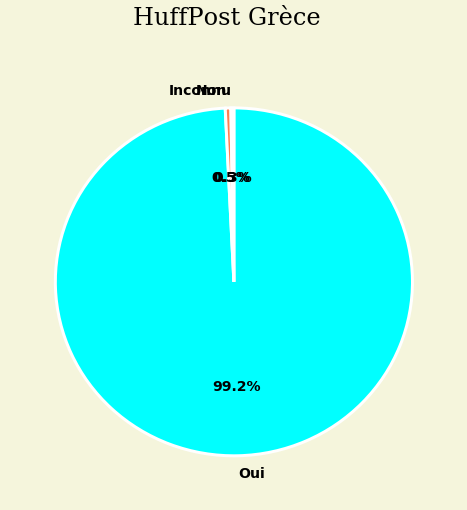

In [17]:
camembert = pd.Series([HP_oui,HP_non,HP_inconnu], index=["Oui","Non","Inconnu"],name="")
titre = plt.figure(facecolor="beige")
titre.suptitle("HuffPost Grèce", fontsize=24, fontweight="light", fontname="Serif")
camembert.plot.pie(colors=["aqua","coral","lightgrey"],
                   wedgeprops={"linewidth":3,"edgecolor":"white"},
                   textprops={"weight":"bold","fontsize":14},
                   counterclock=False,
                   startangle=90,
                   autopct="%1.1f%%",
                   figsize=(8,8)
)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 6 - Exercice boni&nbsp;: les étiquettes (<i>tags</i>)</h3>

Chaque article du *Huffington Post* est généralement accompagné d'une dizaine de marqueurs, ou d'étiquettes (*tags* en anglais). Voici ceux qui sont le plus fréquemment utilisés par cette édition.

In [18]:
etiquettes = huff.set_index('pays').tags.str.split(',', expand=True).stack().rename(columns={0:'tag'}).reset_index(drop=True)
etiquettes.value_counts(dropna=False)

ΔΙΕΘΝΕΣ                                                                             15889
ΠΟΛΙΤΙΚΗ                                                                            12347
ΚΟΙΝΩΝΙΑ                                                                            9880 
ΟΙΚΟΝΟΜΙΑ                                                                           7588 
life                                                                                4455 
gr-viral                                                                            3741 
culture                                                                             2823 
Ελλάδα                                                                              2612 
ΑΘΛΗΤΙΣΜΟΣ                                                                          2200 
ΗΠΑ                                                                                 2177 
ΜΕΤΑΝΑΣΤΕΥΤΙΚΟ                                                                      1745 
ΣΥΡΙΖΑ    